# Beetaloo: Results (max_iter=1)

In [1]:
# import libraries
import numpy as np
import pandas as pd
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1. Data Pre-processing

In [2]:
# beetaloo dataset
beetaloo = pd.read_csv(filepath_or_buffer='dataset_beetaloo.csv', low_memory=False)
beetaloo.head()

,WELL_ID,YEAR,LATITUDE,LONGITUDE,DEPTH,DENSITY,GR,SONIC,RESISTIVITY,SP,NEUTRON,CALIPER,BITSIZE,TOC_CORE,TOC_CUTTINGS,LITHO,ORDER_3,ORDER_4
0,Alexander_1,1988.0,-15.16911,134.855921,63.1,NaN,111.753,NaN,NaN,NaN,NaN,4.705,NaN,NaN,NaN,Velkerri Formation,HST-2,RST-2.5
1,Alexander_1,1988.0,-15.16911,134.855921,63.2,NaN,108.300,NaN,NaN,NaN,NaN,4.701,NaN,NaN,NaN,Velkerri Formation,HST-2,RST-2.5
2,Alexander_1,1988.0,-15.16911,134.855921,63.3,NaN,105.699,NaN,NaN,NaN,NaN,4.676,NaN,NaN,NaN,Velkerri Formation,HST-2,RST-2.5
3,Alexander_1,1988.0,-15.16911,134.855921,63.4,NaN,106.119,NaN,NaN,NaN,NaN,4.668,NaN,NaN,NaN,Velkerri Formation,HST-2,RST-2.5
4,Alexander_1,1988.0,-15.16911,134.855921,63.5,NaN,106.734,NaN,NaN,NaN,NaN,4.691,NaN,NaN,NaN,Velkerri Formation,HST-2,RST-2.5


In [3]:
# complete the location of some wells
wells_no_location = ['Balmain_1', 'Birdum_Creek_1', 'Broadmere_1', 'Jamison_1', 'Lady_Penrhyn_1', 'Marmbulligan_1', 'Ronald_1', 'Scarborough_1', 'Sever_1', 'Tarlee_1', 'Walton_2', 'Wyworrie_1']

x_coord = [-92402.40724, 142017.0021, -24907.23409, -501.9841485, 82970.28312, 17486.61935, 86665.76837, -125242.803, -124956.7945, -38322.74503, -135702.1635]
y_coord = [-1809383.515, -1887528.408, -1936401.136, -1747313.691, -1872700.38, -1877801.953, -1759280.809, -1766817.469, -1845740.884, -1839970.706, -1780656.283]

lat = [-16.620444] 
lon = [133.577361]

# convert GDA94 to WGS84
import pyproj
# GDA94 / Geoscience Australia Lambert, EPSG:3112
# WGS 84 -- WGS84 - World Geodetic System 1984, used in GPS, EPSG:4326
gda94_wgs84 = pyproj.Transformer.from_crs(3112, 4326)
for i in range(len(x_coord)):
    new_coord = gda94_wgs84.transform(x_coord[i], y_coord[i])
    lat.append(new_coord[0])
    lon.append(new_coord[1])

# replace coordinates in the dataset
for i in range(len(wells_no_location)):
    beetaloo.loc[beetaloo['WELL_ID'] == wells_no_location[i], 'LATITUDE'] = lat[i]
    beetaloo.loc[beetaloo['WELL_ID'] == wells_no_location[i], 'LONGITUDE'] = lon[i]
    
# rename columns
beetaloo.rename(columns={'LONGITUDE': 'X',
                         'LATITUDE' : 'Y',
                         'DENSITY': 'RHOB', 
                         'SONIC': 'DT',
                         'RESISTIVITY': 'RES', 
                         'NEUTRON': 'NPHI',
                         'ORDER_4': 'STRAT'
                        }, inplace=True
               )

# drop unnecessary columns
beetaloo.drop(['YEAR', 'CALIPER', 'BITSIZE', 'TOC_CORE', 'TOC_CUTTINGS', 'ORDER_3'], axis=1, inplace=True)

# handle outliers and well-log transformation

# replace sonic values smaller than 0 for NaN values
mask = beetaloo['DT'] < 0
beetaloo.loc[mask, 'DT'] = np.nan

# replace resistivity values smaller than or equal to 0 for NaN values
mask = beetaloo['RES'] <= 0
beetaloo.loc[mask, 'RES'] = np.nan

# create a new column to store log base 10 of resistivity
beetaloo['RES_10'] = np.log10(beetaloo['RES']+1)

# replace neutron porosity values smaller than 0 for NaN values
mask = beetaloo['NPHI'] < 0
beetaloo.loc[mask, 'NPHI'] = np.nan

# convert percentage to fraction
def convert_neutron(x):
    if x >= 1:
        return x / 100
    else:
        return x

beetaloo['NPHI'] = beetaloo['NPHI'].apply(convert_neutron)

In [4]:
# label encoding for well id
well_encoder = LabelEncoder()
beetaloo['WELL'] = well_encoder.fit_transform(beetaloo['WELL_ID'])

# feature selection
selected_features = ['WELL', 'X', 'Y', 'DEPTH', 
                     'RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI',
                     'LITHO', 'STRAT']

## 2. Data Splitting

In [5]:
# copy of the dataset for modeling
data_ml = beetaloo[selected_features].copy()

In [6]:
# well test selection
test_wells = well_encoder.transform(['Tarlee_2', 'Beetaloo_W1', 'Friendship_1', 'Burdo_1', 'McManus_1', 'Amungee_NW1'])

# mask for test well
test_mask = data_ml['WELL'].isin(test_wells)

# column to identify train and test wells
data_ml['train_test'] = 'Train'
data_ml.loc[test_mask, 'train_test'] = 'Test'

# fraction of data
train_fraction = data_ml[data_ml['train_test'] == 'Train'].shape[0] / data_ml.shape[0]
test_fraction = data_ml[data_ml['train_test'] == 'Test'].shape[0] / data_ml.shape[0]
print(f"Fraction of data in train set: {train_fraction:.2f}")
print(f"Fraction of data in test set: {test_fraction:.2f}")
print(f"Total number of samples in dataset: {data_ml.shape[0]}")

Fraction of data in train set: 0.83
Fraction of data in test set: 0.17
Total number of samples in dataset: 352143


In [7]:
# create train and test sets
train = data_ml[~test_mask].copy()
test = data_ml[test_mask].copy()

## 3. Results

### Test

In [8]:
# results from mice
test_result_knr = pd.read_csv('test_result_knr.csv').add_suffix('_KNR')
test_result_br = pd.read_csv('test_result_br.csv').add_suffix('_BR')
test_result_rf = pd.read_csv('test_result_rf.csv').add_suffix('_RF')
test_result_xgb = pd.read_csv('test_result_xgb.csv').add_suffix('_XGB')

In [9]:
test_df = test.copy()
test_df.reset_index(drop=True, inplace=True)

# merge mice results with the test data
test_df = test_df.merge(test_result_knr, left_index=True, right_index=True)
test_df = test_df.merge(test_result_br, left_index=True, right_index=True)
test_df = test_df.merge(test_result_rf, left_index=True, right_index=True)
test_df = test_df.merge(test_result_xgb, left_index=True, right_index=True)


In [10]:
test_df

,WELL,X,Y,DEPTH,RHOB,GR,DT,RES_10,SP,NPHI,...,DT_IMP_SCALED_XGB,RES_10_IMP_SCALED_XGB,SP_IMP_SCALED_XGB,NPHI_IMP_SCALED_XGB,RHOB_IMP_XGB,GR_IMP_XGB,DT_IMP_XGB,RES_10_IMP_XGB,SP_IMP_XGB,NPHI_IMP_XGB
0,2,133.884556,-16.347509,1192.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.368344,0.203492,0.664596,0.180927,2.536945,51.869107,72.495164,1.017808,54.778841,0.180203
1,2,133.884556,-16.347509,1237.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.400575,0.221094,0.690262,0.260639,2.620001,179.819598,76.207374,1.105810,67.852034,0.259596
2,2,133.884556,-16.347509,1272.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.400575,0.221094,0.690262,0.260639,2.620001,179.819598,76.207374,1.105810,67.852034,0.259596
3,2,133.884556,-16.347509,1312.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.400575,0.221094,0.690262,0.260639,2.620001,179.819598,76.207374,1.105810,67.852034,0.259596
4,2,133.884556,-16.347509,1352.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.365649,0.280387,0.749070,0.210497,2.642305,156.645300,72.184726,1.402250,97.807495,0.209655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60732,28,132.683458,-15.890177,1181.862,NaN,NaN,NaN,NaN,NaN,NaN,...,0.514951,0.211019,NaN,0.235013,2.613359,119.864936,89.381018,1.055438,NaN,0.234073
60733,28,132.683458,-15.890177,1182.014,NaN,NaN,NaN,NaN,NaN,NaN,...,0.514951,0.211019,NaN,0.235013,2.613359,119.864936,89.381018,1.055438,NaN,0.234073
60734,28,132.683458,-15.890177,1182.167,NaN,NaN,NaN,NaN,NaN,NaN,...,0.514951,0.211019,NaN,0.235013,2.613359,119.864936,89.381018,1.055438,NaN,0.234073
60735,28,132.683458,-15.890177,1182.319,NaN,NaN,NaN,NaN,NaN,NaN,...,0.514951,0.211019,NaN,0.235013,2.613359,119.864936,89.381018,1.055438,NaN,0.234073


### 3.1. MICE Performance

In [11]:
well_logs = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI']
models = ['KNR', 'BR', 'RF', 'XGB']

evaluation_results = {}
for log in well_logs:
    
    evaluation_results[log] = {}
    for model in models:

        column_name = f'{log}_{model}'
        
        original_values = test_df[f'{log}_SCALED_{model}'].dropna()
        original_index = list(original_values.index.values)
        imputed_values = test_df.loc[original_index, f'{log}_IMP_SCALED_{model}']
        
        mae = mean_absolute_error(original_values, imputed_values)
        mse = mean_squared_error(original_values, imputed_values)
        r2 = r2_score(original_values, imputed_values)
        
        evaluation_results[log][model] = {'R2': r2, 'NMAE': mae, 'NMSE': mse}

evaluation_results_df = {}
for log, models in evaluation_results.items():
    
    table_data = []
    for model, metrics in models.items():
        cols = {'Model': model, 'R2': metrics['R2'], 'NMAE': metrics['NMAE'], 'NMSE': metrics['NMSE']}
        table_data.append(cols)
    
    df = pd.DataFrame(table_data)
    
    evaluation_results_df[log] = df

for log, df in evaluation_results_df.items():
    print(f'Well-log: {log}')
    display(df.round(4).sort_values('NMSE', ascending=True))
    print('\n')

Well-log: RHOB


,Model,R2,NMAE,NMSE
3,XGB,0.3347,0.0134,0.0004
0,KNR,-0.4591,0.0185,0.0009
1,BR,-0.4436,0.0214,0.0009
2,RF,-1.4031,0.0194,0.0015




Well-log: GR


,Model,R2,NMAE,NMSE
2,RF,0.4755,0.0875,0.0143
3,XGB,0.3316,0.0964,0.0182
0,KNR,0.2260,0.1013,0.0211
1,BR,-0.3184,0.1541,0.0359




Well-log: DT


,Model,R2,NMAE,NMSE
2,RF,0.3081,0.0470,0.0045
3,XGB,0.2466,0.0530,0.0050
0,KNR,-0.1970,0.0626,0.0079
1,BR,-0.4194,0.0818,0.0093




Well-log: RES_10


,Model,R2,NMAE,NMSE
1,BR,-0.0298,0.0570,0.0060
3,XGB,-0.0679,0.0565,0.0062
2,RF,-0.1715,0.0571,0.0068
0,KNR,-0.7908,0.0633,0.0104




Well-log: SP


,Model,R2,NMAE,NMSE
0,KNR,-12.0361,0.1851,0.0561
2,RF,-14.9351,0.2250,0.0686
3,XGB,-15.6937,0.2369,0.0719
1,BR,-16.7225,0.2620,0.0763




Well-log: NPHI


,Model,R2,NMAE,NMSE
1,BR,0.3109,0.0430,0.0026
0,KNR,0.2766,0.0434,0.0027
2,RF,0.2488,0.0425,0.0029
3,XGB,0.1171,0.0491,0.0034


In [12]:
r2_results_df = pd.DataFrame()
mae_results_df = pd.DataFrame()
mse_results_df = pd.DataFrame()

for log, df in evaluation_results_df.items():
    r2_results_df[log] = df['R2']
    mae_results_df[log] = df['NMAE']
    mse_results_df[log] = df['NMSE']

r2_results_df.index = df['Model']
mae_results_df.index = df['Model']
mse_results_df.index = df['Model']
    

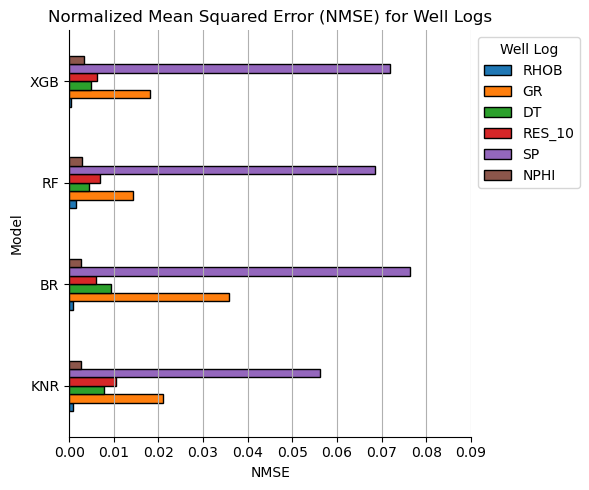

Model,KNR,BR,RF,XGB
RHOB,0.0009,0.0009,0.0015,0.0004
GR,0.0211,0.0359,0.0143,0.0182
DT,0.0079,0.0093,0.0045,0.0050
RES_10,0.0104,0.0060,0.0068,0.0062
SP,0.0561,0.0763,0.0686,0.0719
NPHI,0.0027,0.0026,0.0029,0.0034


In [15]:
ax = mse_results_df.plot(kind='barh', figsize=(6, 5), edgecolor='black')

plt.title('Normalized Mean Squared Error (NMSE) for Well Logs')
plt.ylabel('Model')
plt.xlabel('NMSE')

plt.xticks(rotation='horizontal')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.grid(True)
ax.legend(title='Well Log', bbox_to_anchor=(1, 1))

ax.set_xlim([0, 0.09])

plt.tight_layout() 
plt.show()

display(mse_results_df.T.round(4))

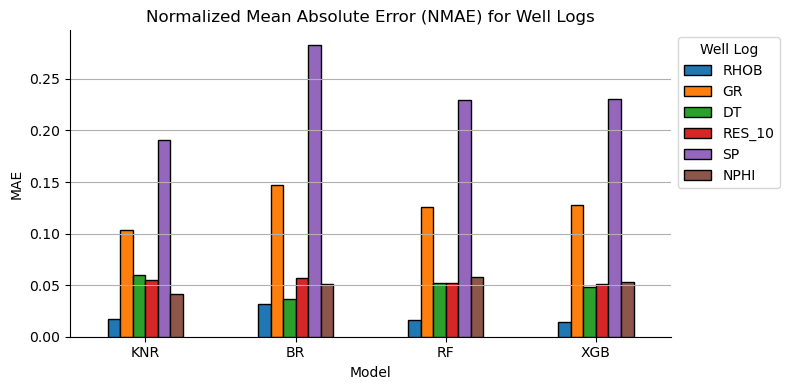

Model,KNR,BR,RF,XGB
RHOB,0.0177,0.0316,0.0166,0.0145
GR,0.1038,0.1473,0.1261,0.1274
DT,0.0594,0.0364,0.0518,0.0478
RES_10,0.0550,0.0566,0.0517,0.0506
SP,0.1908,0.2830,0.2298,0.2307
NPHI,0.0417,0.0507,0.0577,0.0528


In [20]:
ax = mae_results_df.plot(kind='bar', figsize=(8, 4), edgecolor='black')

plt.title('Normalized Mean Absolute Error (NMAE) for Well Logs')
plt.xlabel('Model')
plt.ylabel('MAE')

plt.xticks(rotation='horizontal')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(True)
ax.legend(title='Well Log', bbox_to_anchor=(1, 1))

plt.tight_layout() 
plt.show()

# ax.set_ylim([0, 0.1])

display(mae_results_df.T.round(4))


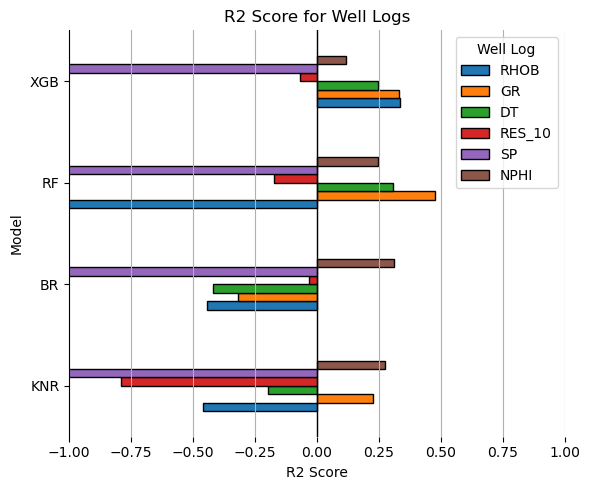

Model,KNR,BR,RF,XGB
RHOB,-0.46,-0.44,-1.40,0.33
GR,0.23,-0.32,0.48,0.33
DT,-0.20,-0.42,0.31,0.25
RES_10,-0.79,-0.03,-0.17,-0.07
SP,-12.04,-16.72,-14.94,-15.69
NPHI,0.28,0.31,0.25,0.12


In [14]:
ax = r2_results_df.plot(kind='barh', figsize=(6, 5), edgecolor='black')

plt.title('R2 Score for Well Logs')
plt.ylabel('Model')
plt.xlabel('R2 Score')
ax.legend(title='Well Log', bbox_to_anchor=(1, 1))
plt.xticks(rotation='horizontal')
plt.axvline(0, color='black', linewidth=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.xaxis.grid(True)

ax.set_xlim([-1, 1])

plt.tight_layout()  
plt.show()
display(r2_results_df.T.round(2))
